# **IMPORTING LIBRARIES AND FILES**

In [1]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import torch

In [2]:
!pip install sentence-transformers

In [3]:
data_descriptions = pd.read_csv('ml_insurance_challenge.csv')
initial_descriptions = data_descriptions
data_taxonomy = pd.read_excel('insurance_taxonomy.xlsx')

In [4]:
data_descriptions.head()

,description,business_tags,sector,category,niche
0,Welchcivils is a civil engineering and constru...,"['Construction Services', 'Multi-utilities', '...",Services,Civil Engineering Services,Other Heavy and Civil Engineering Construction
1,"Kyoto Vegetable Specialists Uekamo, also known...","['Wholesale', 'Dual-task Movement Products', '...",Manufacturing,Fruit & Vegetable - Markets & Stores,"Frozen Fruit, Juice, and Vegetable Manufacturing"
2,Loidholdhof Integrative Hofgemeinschaft is a c...,"['Living Forms', 'Farm Cafe', 'Fresh Coffee', ...",Manufacturing,Farms & Agriculture Production,All Other Miscellaneous Crop Farming
3,PATAGONIA Chapa Y Pintura is an auto body shop...,"['Automotive Body Repair Services', 'Interior ...",Services,Auto Body Shops,"Automotive Body, Paint, and Interior Repair an..."
4,Stanica WODNA PTTK Swornegacie is a cultural e...,"['Cultural Activities', 'Accommodation Service...",Services,Boat Tours & Cruises,"Scenic and Sightseeing Transportation, Water"


In [5]:
data_taxonomy.head()

,label
0,Agricultural Equipment Services
1,Soil Nutrient Application Services
2,Pesticide Application Services
3,Ornamental Plant Nurseries
4,Landscaping Services


In [6]:
print(data_descriptions.columns)

Index(['description', 'business_tags', 'sector', 'category', 'niche'], dtype='object')


In [7]:
print(data_taxonomy.columns)

Index(['label'], dtype='object')


In [8]:
print(type(data_descriptions))

<class 'pandas.core.frame.DataFrame'>


# **CLEANING THE DATASETS**

**DESCRIPTIONS FOR FEATURES**

Here, I have checked whether I have empty values of any kind in the columns of both datasets. I have found that in the business_tags for the insurance companies I have 365 empty list values. Therefore, I have filled them with NA values, since initially I was going for filling the empty list values with the most common business_tag. Since all of them were unique, I decided that is best to avoid introducing arbitrary estimates and to preserve data integrity.

In [9]:
for column in data_descriptions.columns:
  print(f"for {column} we have : {(data_descriptions[column] == '[]').sum()} empty lists")
  print(f"for {column} we have : {(data_descriptions[column] == None).sum()} None values")
  print(f"for {column} we have : {(data_descriptions[column] == pd.NA).sum()} NA values")



for description we have : 0 empty lists
for description we have : 0 None values
for description we have : 0 NA values
for business_tags we have : 363 empty lists
for business_tags we have : 0 None values
for business_tags we have : 0 NA values
for sector we have : 0 empty lists
for sector we have : 0 None values
for sector we have : 0 NA values
for category we have : 0 empty lists
for category we have : 0 None values
for category we have : 0 NA values
for niche we have : 0 empty lists
for niche we have : 0 None values
for niche we have : 0 NA values


In [10]:
data_descriptions['business_tags'].fillna(pd.NA, inplace=True)

/tmp/ipython-input-1568580976.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_descriptions['business_tags'].fillna(pd.NA, inplace=True)


**DESCRIPTIONS FOR INSURANCES**

In [11]:
for column in data_taxonomy.columns:
  print(f"for {column} we have : {(data_taxonomy[column] == '[]').sum()} empty list values")
  print(f"for {column} we have : {(data_taxonomy[column] == None).sum()} None values")
  print(f"for {column} we have : {(data_taxonomy[column] == pd.NA).sum()} NA values")

for label we have : 0 empty list values
for label we have : 0 None values
for label we have : 0 NA values


# **WORKING WITH THE DATA**

In [12]:
model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Here I am selecting the descpriptions of each insurance company and turn it into a list so that it can be passed to the model to be encoded. The reason I am doing this is for the model to form a abasic idea about every company an then to associate a label for each one. Speaking of labels, I am selecting those from the taxonomy dataset, and also encoding them. The model does not understand words like humans do. They have to be mapped or coded into numbers. In this way, they are able to understand the information.

I went with the description column in the insurance_dataset, because I looked throught the dataset and is the column sustaining the most information about what the insurance company does. And from the other dataset I just took the labels which was the only column in the entire dataset.

In [13]:
texts = data_descriptions['description'].astype(str).tolist()
labels = data_taxonomy['label'].astype(str).tolist()

In [14]:
text_embeddings = model.encode(texts, convert_to_tensor=True)
label_embeddings = model.encode(labels, convert_to_tensor=True)

Here, I was curios about the shapes of the embedded texts and found out that the first member of the shape tuple is the number of the texts or labels from the dataset and the other member is 384 in both cases. I did some research and found out that the number, 384, is the text mapped or coded in 384 real values. All these 384 values, together they represent the sense, or the context or the main idea of the text. Basically the model needs these 384 real values to get the meaning of the text, like humans do when they hear a sentence and deduct its meainig

In [15]:
print(text_embeddings.shape) # the shape is (number_of_texts_from_the_description_column_in_the_dataset, number_of_real_values)
print(label_embeddings.shape) # the shape is (number_of_labels_from_the_insurance_dataset, number_of_real_values)

torch.Size([9494, 384])
torch.Size([220, 384])


In [16]:
print(text_embeddings[0])

tensor([-9.0365e-02,  1.8257e-02, -1.3549e-02, -3.5639e-02, -9.7254e-02,
        -8.1989e-02,  4.8303e-03,  1.8673e-02, -6.5049e-02, -5.5995e-03,
        -8.6309e-02, -5.8753e-02,  5.5974e-02,  3.6943e-02, -7.2095e-02,
        -2.7580e-02, -1.7733e-02, -6.0399e-02,  7.1785e-02, -3.5431e-02,
         3.5174e-02,  4.3562e-02,  5.2416e-02, -5.6490e-02,  3.6621e-02,
         7.5421e-02,  3.7041e-02,  7.0756e-02,  2.0357e-02, -3.4237e-02,
         2.0311e-02, -1.3636e-02, -2.1469e-02, -5.6941e-02,  1.9591e-02,
         4.1282e-02,  1.2398e-02,  1.2928e-02, -1.2583e-02,  2.2696e-02,
        -7.6250e-02, -1.5066e-02,  3.4636e-02,  7.4597e-03, -8.3905e-02,
        -1.7513e-02,  3.2363e-02,  3.6724e-02, -4.6831e-02, -1.1089e-01,
         2.1418e-02, -6.3739e-02, -3.8827e-02, -1.4296e-02,  5.6160e-02,
         1.9749e-02, -2.0940e-02, -1.7850e-02, -3.5973e-02, -2.7480e-02,
         1.2330e-01, -3.8516e-02, -7.3158e-02,  9.0325e-02, -1.1286e-02,
         5.8590e-02, -9.0404e-03,  6.9775e-02, -4.4

Here I am going through each encoded text and calculate the similarity using cos_sim to see what labels suits the text best. Then I take the one with the highest score and, these predictions are placed in a new column from the insurance_companies descriptions dataset.

In [17]:
predicted_labels = []
max_values = []
for text_encoded in text_embeddings:
  similarity = util.cos_sim(text_encoded, label_embeddings)
  best_match = torch.argmax(similarity).item()
  predicted_labels.append(labels[best_match])

  max_val = similarity.max().item()
  max_values.append(max_val)

data_descriptions['predicted_label'] = predicted_labels

In [18]:
data_descriptions.to_csv('labeled_insurance_companies.csv')
files.download('labeled_insurance_companies.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **EVALUATING THE DATA**

For the evaluation metrics, I decided not to follow the traditional approach using accuracy, precision, recall, f1-score. The reason being, the insurance_companies dataset didn't come with a feature of labels, but instead I had to make one and I have used some sort of semantic deduction to do so. Therefore, I couldn't have used these metrics to evaluate the model because, I had to compare the true labels or the original labels with the predicted ones and from the above implementation, the chosen model doesn't work this way. I have chosen a mean value that resulted from the cosine similitude which varies usually from -1 to 1 to see how the model feels about its own deduction on the data.

Another metric used was TSNE, to visualize the semantic structure of the texts and their predicted labels, highlighting differences and clusters that are not evident in the original high-dimensional space.

Here the value is between -1 and 1. Cosine similarity represents the similitude between the coded text and coded label and it varies between -1 and 1. In my case is 0.37 which is positive but not too great either, which shows that the model could be unsure on its own associations.

In [19]:
print("Mean max similarity:", sum(max_values)/len(max_values))

Mean max similarity: 0.37238300937789603


Here, in this TSNE plot a point is a text and the colors are the labels associated with the texts. In this case we can observe that it tries to form some sort of grouping, but there are still colors of blue among yellow and colors of yellow among green. It looks like the moddel is unsure in some cases.

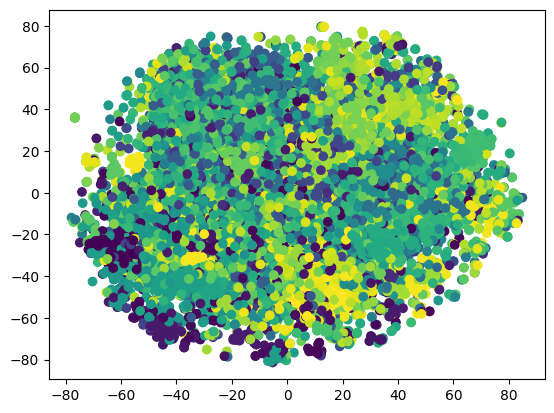

In [21]:
embeddings_2d = TSNE(n_components=2).fit_transform(text_embeddings.cpu())
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=[labels.index(l) for l in predicted_labels])
plt.show()

# **DIFFERENT APPROACH**

I am going to try a different approach, in hopes of getting a much better result. I have decided to go for the mpnet base model. I have done some research and found out that it represents the text's context or main idea in 768 real values. This could mean a couple of things, for instance it could catch more subtle details, however it takes more time. For example, on the CPU, MiniLM-L6-v2 took about 10 minutes to encode the texts and the labels and with the new model it takes 60 minutes. I will compare the 2 with mean max value and embeddings scatterplot.

In [22]:
model_2 = SentenceTransformer("all-mpnet-base-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [23]:
data_descriptions_2 = initial_descriptions

In [24]:
v2_text_embeddings = model_2.encode(texts, convert_to_tensor=True)
v2_label_embeddings = model_2.encode(labels, convert_to_tensor=True)

Here we can notice that the all-mpnet-base model represents the meaning or sense of the text in 768 real values, compared to 384 from the all-MiniLM-L6 model. This suggests that the all-mpnet-base model remembers more details about the text than the all-MiniLM-L6 model.

In [25]:
print(v2_text_embeddings.shape) # the shape is (number_of_texts_from_the_description_column_in_the_dataset, number_of_real_values)
print(v2_label_embeddings.shape) # the shape is (number_of_labels_from_the_insurance_dataset, number_of_real_values)

torch.Size([9494, 768])
torch.Size([220, 768])


In [26]:
print(v2_text_embeddings[0])

tensor([-6.4879e-02,  2.9642e-02,  1.0939e-02,  1.8529e-02, -1.0565e-03,
        -6.2461e-04,  5.0106e-02, -6.2975e-02, -1.0813e-02, -2.1751e-02,
         5.8429e-02,  5.0621e-02,  4.2595e-02, -4.8220e-03,  3.8306e-02,
         1.8612e-02, -4.3832e-02,  1.7510e-02, -1.0769e-01,  2.4687e-02,
         1.1240e-02,  1.5288e-02,  6.4908e-03,  5.5131e-03, -3.5713e-02,
         1.2903e-02, -9.4816e-03, -5.3553e-03,  2.2884e-02, -4.1225e-02,
         7.6576e-02,  1.7824e-02, -8.0893e-02,  3.0566e-02,  2.1837e-06,
        -4.8170e-03, -5.8144e-03, -1.8023e-02, -1.0840e-02,  2.4283e-02,
        -3.3211e-02, -7.5448e-02,  7.0230e-03, -5.8095e-03, -3.0642e-02,
         5.0419e-02,  5.5542e-02, -2.0997e-02,  7.3094e-03,  1.2097e-03,
        -2.5049e-02, -6.2301e-02, -6.7307e-02, -3.3539e-02,  2.2995e-02,
        -5.9964e-02, -1.9376e-02,  3.4365e-02,  2.3756e-02,  4.8331e-02,
         3.5991e-03,  1.2992e-03, -1.0428e-02,  2.4402e-02,  6.5454e-02,
         1.2217e-02,  2.3430e-02, -8.5348e-03, -4.8

In [27]:
predicted_labels_2 = []
max_values_2 = []

for encoded_text in v2_text_embeddings:
  similarity = util.cos_sim(encoded_text, v2_label_embeddings)
  best_index = torch.argmax(similarity).item()
  predicted_labels_2.append(labels[best_index])

  max_values_2.append(similarity.max().item())

data_descriptions_2['predicted_label'] = predicted_labels_2

In [28]:
data_descriptions_2.to_csv('labeled_insurance_companies_2.csv')
files.download('labeled_insurance_companies_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
print("Mean max similarity:", sum(max_values_2)/len(max_values_2))

Mean max similarity: 0.39804760953134827


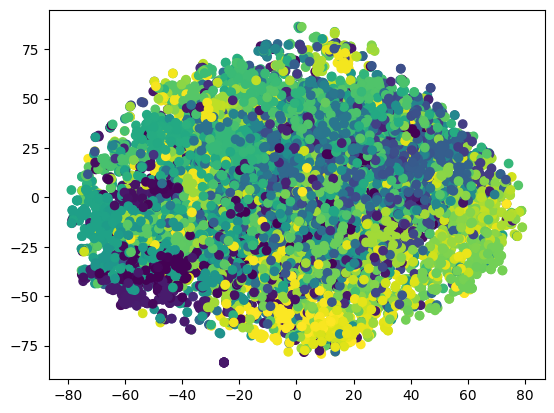

In [30]:
embeddings_2d = TSNE(n_components=2).fit_transform(v2_text_embeddings.cpu())
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=[labels.index(l) for l in predicted_labels_2])
plt.show()

After receiving both of the results, from the performance metrics we can observe a couple o things:
1. From the Mean Max similarity, it has only increased by around 0.02, and the model is still not very sure on its own predictions
2. From the scatter plot in this case, it seems like the separation is done better than the previous case, but there are stil colors mixed where they shouldn't be.

Therefore, even though the second model represents the sense of the text in a much more complex manner, it doesn/t necessarly means that it is going to perform a lot better and also given the inference time tradeoff between the 2, I would go with the first model.

/tmp/ipython-input-572415643.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


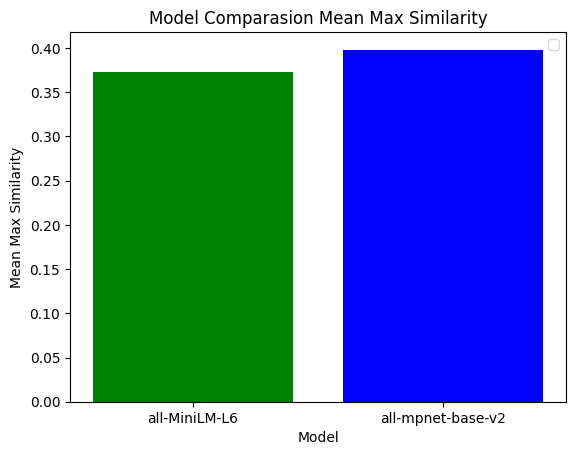

In [31]:

mean_1 = sum(max_values)/len(max_values)
mean_2 = sum(max_values_2)/len(max_values_2)

x = [mean_1, mean_2]

labels_plot = ['all-MiniLM-L6', 'all-mpnet-base-v2']
plt.bar(labels_plot, x, color=['green', 'blue'])
plt.title('Model Comparasion Mean Max Similarity')
plt.xlabel('Model')
plt.ylabel('Mean Max Similarity')
plt.xticks(range(len(x)), labels_plot)
plt.legend()
plt.show()

# **A SECOND DIFFERENT APPROACH**

Compared to the other 2 models, this one took around 120 minutes on the CPU to finish sencoding the data, which can be explained by the fact that it represents the meaning of the text using 1024 real numbers.

In [32]:
model_3 = SentenceTransformer("all-roberta-large-v1")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [33]:
data_descriptions_3 = initial_descriptions

In [34]:
v3_text_embeddings = model_3.encode(texts, convert_to_tensor=True)
v3_label_embeddings = model_3.encode(labels, convert_to_tensor=True)

We can notice that this model represents the sense of the text in 1024 real numbers.

In [35]:
print(v3_text_embeddings.shape) # the shape is (number_of_texts_from_the_description_column_in_the_dataset, number_of_real_values)
print(v3_label_embeddings.shape) # the shape is (number_of_labels_from_the_insurance_dataset, number_of_real_values)

torch.Size([9494, 1024])
torch.Size([220, 1024])


In [36]:
predicted_labels_3 = []
max_values_3 = []
for text_encoded in v3_text_embeddings:
  similarity = util.cos_sim(text_encoded, v3_label_embeddings)
  best_match = torch.argmax(similarity).item()
  predicted_labels_3.append(labels[best_match])

  max_values_3.append(similarity.max().item())

data_descriptions_3['predicted_labels'] = predicted_labels_3

In [37]:
data_descriptions_3.to_csv('labeled_insurance_companies_3.csv')
files.download('labeled_insurance_companies_3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
print("Mean max similarity:", sum(max_values_3)/len(max_values_3))

Mean max similarity: 0.3812470016999071


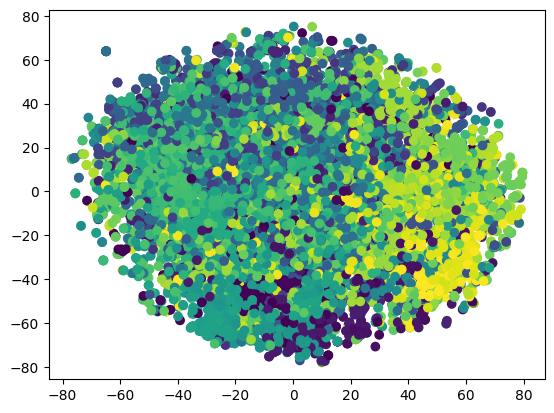

In [39]:
embeddings_2d = TSNE(n_components=2).fit_transform(v3_text_embeddings.cpu())
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=[labels.index(l) for l in predicted_labels_3])
plt.show()

Here, I was disappointed because when I have found out that it needs 1024 real values to represent the meaning of the text, I thought that it is going to have a much better performance. Turns out it is not like that. Depends on the data the model has been trained on. For example, roberta is fine-tuned on more general data and maybe it can't learn or memorise the embeddings effectively for a semantic task which relates to this case a lot.

/tmp/ipython-input-1028770633.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


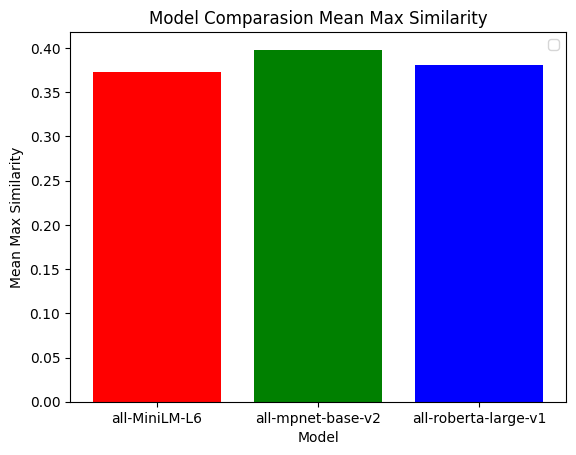

In [40]:
mean_1 = sum(max_values)/len(max_values)
mean_2 = sum(max_values_2)/len(max_values_2)
mean_3 = sum(max_values_3)/len(max_values_3)
x = [mean_1, mean_2, mean_3]
labels_comp = ['all-MiniLM-L6', 'all-mpnet-base-v2', 'all-roberta-large-v1']

plt.bar(labels_comp, x, color=['red', 'green', 'blue'])
plt.title('Model Comparasion Mean Max Similarity')
plt.xlabel('Model')
plt.ylabel('Mean Max Similarity')
plt.xticks(range(len(x)), labels_comp)
plt.legend()
plt.show()

# **A THIRD DIFFERENT APPROACH**

I have chosen this model, because it is fine-tuned on question answer retrieval and semantic classification, which I have thought that it is suitable for this assignment. This model took aroun 70 minutes, on the CPU, to encode the data, pretty similar to the mpnet-base model inference time wise.

In [41]:
model_4 = SentenceTransformer("multi-qa-mpnet-base-dot-v1")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [42]:
data_descriptions_4 = initial_descriptions

In [43]:
v4_text_embeddings = model_4.encode(texts, convert_to_tensor=True)
v4_label_embeddings = model_4.encode(labels, convert_to_tensor=True)

We can notice the fact that this model requires the same number of real numbers to represent the sense of the text like the all-mpnet-base-v2 model.

In [44]:
print(v4_text_embeddings.shape) # the shape is (number_of_texts_from_the_description_column_in_the_dataset, number_of_real_values)
print(v4_label_embeddings.shape) # the shape is (number_of_labels_from_the_insurance_dataset, number_of_real_values)

torch.Size([9494, 768])
torch.Size([220, 768])


In [45]:
predicted_labels_4 = []
max_values_4 = []
for text_encoded in v4_text_embeddings:
  similarity = util.cos_sim(text_encoded, v4_label_embeddings)
  best_match = torch.argmax(similarity).item()
  predicted_labels_4.append(labels[best_match])

  max_values_4.append(similarity.max().item())

data_descriptions_4['predicted_labels'] = predicted_labels_4

In [46]:
data_descriptions_4.to_csv('labeled_insurance_companies_4.csv')
files.download('labeled_insurance_companies_4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

By far, this is the best result so for shich means that this model is more precise than the others.

In [47]:
print("Mean max similarity:", sum(max_values_4)/len(max_values_4))

Mean max similarity: 0.43867702844307654


From this plot we can observe the small groups that are forming with dark blue and yellow and green  but they are still mixed with other types of colors. This implies that is still not very precise.

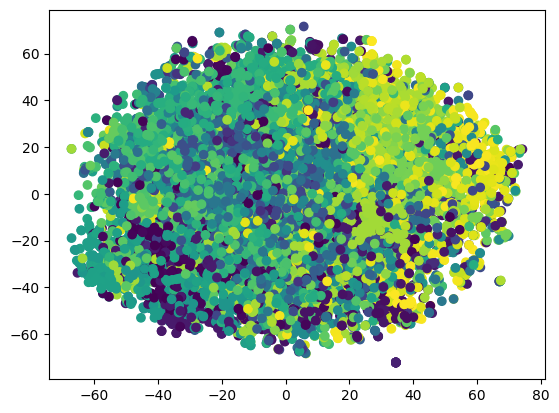

In [48]:
embeddings_2d = TSNE(n_components=2).fit_transform(v4_text_embeddings.cpu())
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=[labels.index(l) for l in predicted_labels_4])
plt.show()

As shown here, this model has the best performance so far !!!

/tmp/ipython-input-3105061279.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


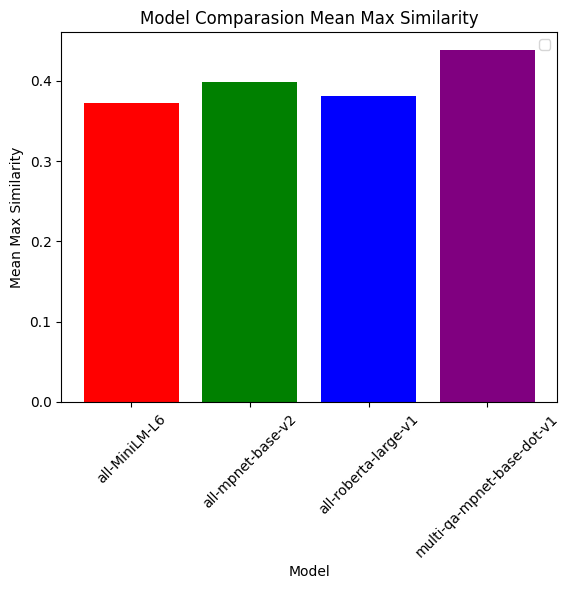

In [49]:
mean_1 = sum(max_values)/len(max_values)
mean_2 = sum(max_values_2)/len(max_values_2)
mean_3 = sum(max_values_3)/len(max_values_3)
mean_4 = sum(max_values_4)/len(max_values_4)
x = [mean_1, mean_2, mean_3, mean_4]
labels_comp = ['all-MiniLM-L6', 'all-mpnet-base-v2', 'all-roberta-large-v1', 'multi-qa-mpnet-base-dot-v1']

plt.bar(labels_comp, x, color=['red', 'green', 'blue', 'purple'])
plt.title('Model Comparasion Mean Max Similarity')
plt.xlabel('Model')
plt.ylabel('Mean Max Similarity')
plt.xticks(range(len(x)), labels_comp, rotation=45)
plt.legend()
plt.show()

# **TUNING THE DATA**

Here I am going to try to see if setting the data to lowercase has better results for all the models that I have tried by now. I have chosen the lowercase data, because I didn't see any special simbols in the ml_insurance_challenge dataset.

In [50]:
texts_lower = [text.lower() for text in texts]
labels_lower = [label.lower() for label in labels]

# **all-MiniLM-L6 MODEL**

In [51]:
data_descriptions = initial_descriptions

In [52]:
text_embeddings = model.encode(texts_lower, convert_to_tensor=True)
label_embeddings = model.encode(labels_lower, convert_to_tensor=True)

****

In [53]:
predicted_labels = []
max_values = []
for text_encoded in text_embeddings:
  similarity = util.cos_sim(text_encoded, label_embeddings)
  best_match = torch.argmax(similarity).item()
  predicted_labels.append(labels[best_match])

  max_val = similarity.max().item()
  max_values.append(max_val)

data_descriptions['predicted_label'] = predicted_labels

In [54]:
print("Mean max similarity:", sum(max_values)/len(max_values))

Mean max similarity: 0.372383009354353


The lowercase data didn't influence much the result of this model, only it has improved it marginally. This is what I can deduce from the mean max similarity score

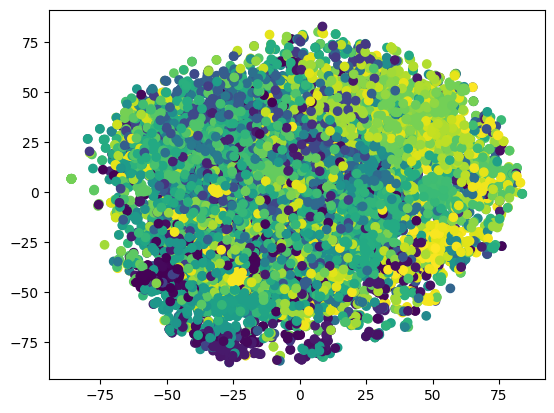

In [55]:
embeddings_2d = TSNE(n_components=2).fit_transform(text_embeddings.cpu())
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=[labels.index(l) for l in predicted_labels])
plt.show()

The plot looks different from the model's performance with the data left in its original form. I will download the labled dataset to look for differences. Somethning looks different in the grouping. It is a little bit more grouped I a see less different colors mixed where there should not be.

In [56]:
data_descriptions.to_csv('labeled_insurance_companies_lowercase.csv')
files.download('labeled_insurance_companies_lowercase.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **all-mpnet-base-v2**

In [57]:
data_descriptions_2 = initial_descriptions

In [58]:
v2_text_embeddings = model_2.encode(texts_lower, convert_to_tensor=True)
v2_label_embeddings = model_2.encode(labels_lower, convert_to_tensor=True)

In [59]:
predicted_labels_2 = []
max_values_2 = []

for encoded_text in v2_text_embeddings:
  similarity = util.cos_sim(encoded_text, v2_label_embeddings)
  best_index = torch.argmax(similarity).item()
  predicted_labels_2.append(labels[best_index])

  max_values_2.append(similarity.max().item())

data_descriptions_2['predicted_label'] = predicted_labels_2

In [60]:
print("Mean max similarity:", sum(max_values_2)/len(max_values_2))

Mean max similarity: 0.3980476095015271


The lowercase data didn't influence much the result of this model, only it has improved it marginally just like for the above model. This is what I can deduce from the mean max similarity score

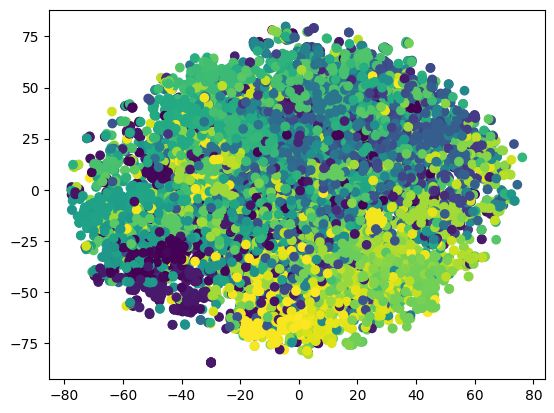

In [61]:
embeddings_2d = TSNE(n_components=2).fit_transform(v2_text_embeddings.cpu())
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=[labels.index(l) for l in predicted_labels_2])
plt.show()

The plot looks different from the model's performance with the data left in its original form. I will download the labled dataset to look for differences. Somethning looks different in the grouping. It is a little bit more grouped I a see less different colors mixed where there should not be.

In [62]:
data_descriptions_2.to_csv('labeled_insurance_companies_2_lowercase.csv')
files.download('labeled_insurance_companies_2_lowercase.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**all-roberta-large-v1**

In [63]:
data_descriptions_3 = initial_descriptions

In [64]:
v3_text_embeddings = model_3.encode(texts_lower, convert_to_tensor=True)
v3_label_embeddings = model_3.encode(labels_lower, convert_to_tensor=True)

In [65]:
predicted_labels_3 = []
max_values_3 = []
for text_encoded in v3_text_embeddings:
  similarity = util.cos_sim(text_encoded, v3_label_embeddings)
  best_match = torch.argmax(similarity).item()
  predicted_labels_3.append(labels[best_match])

  max_values_3.append(similarity.max().item())

data_descriptions_3['predicted_labels'] = predicted_labels_3

In [66]:
print("Mean max similarity:", sum(max_values_3)/len(max_values_3))

Mean max similarity: 0.37880349417036774


The lowercase data decresed the performance for this model. At this point, I don't expect the lowercased data to improve much the next model either. This is what I can deduce from the mean max similarity score

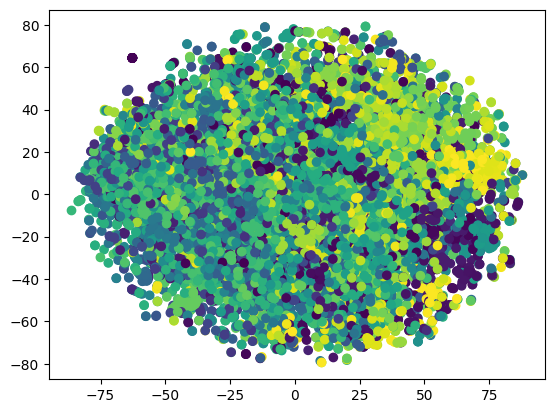

In [67]:
embeddings_2d = TSNE(n_components=2).fit_transform(v3_text_embeddings.cpu())
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=[labels.index(l) for l in predicted_labels_3])
plt.show()

The plot looks different from the model's performance with the data left in its original form. I will download the labled dataset to look for differences. Somethning looks different in the grouping. It is a little bit more grouped I a see less different colors mixed where there should not be.

In [68]:
data_descriptions_3.to_csv('labeled_insurance_companies_3_lowercase.csv')
files.download('labeled_insurance_companies_3_lowercase.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**multi-qa-mpnet-base-dot-v1**

In [69]:
data_descriptions_4 = initial_descriptions

In [70]:
v4_text_embeddings = model_4.encode(texts_lower, convert_to_tensor=True)
v4_label_embeddings = model_4.encode(labels_lower, convert_to_tensor=True)

In [71]:
predicted_labels_4 = []
max_values_4 = []
for text_encoded in v4_text_embeddings:
  similarity = util.cos_sim(text_encoded, v4_label_embeddings)
  best_match = torch.argmax(similarity).item()
  predicted_labels_4.append(labels[best_match])

  max_values_4.append(similarity.max().item())

data_descriptions_4['predicted_labels'] = predicted_labels_4

In [72]:
print("Mean max similarity:", sum(max_values_4)/len(max_values_4))

Mean max similarity: 0.4386770284148249


The lowercase data didn't influence much the result of this model, only it has improved it marginally just as I have suspected. This is what I can deduce from the mean max similarity score

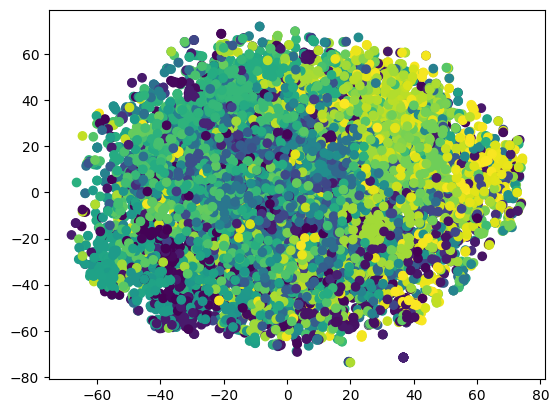

In [73]:
embeddings_2d = TSNE(n_components=2).fit_transform(v4_text_embeddings.cpu())
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1], c=[labels.index(l) for l in predicted_labels_4])
plt.show()

The plot looks different from the model's performance with the data left in its original form. I will download the labled dataset to look for differences. Somethning looks different in the grouping. For this model, it looks a little bit more mixed than before.

In [74]:
data_descriptions_4.to_csv('labeled_insurance_companies_4_lowercase.csv')
files.download('labeled_insurance_companies_4_lowercase.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>